# Data Extraction 

In [60]:
#Imports
import pandas as pd
import numpy as np
import datetime
import os
import warnings
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import doctest
from collections import defaultdict

## Connect to database 

In [2]:
# Load the file 
json_data = json.loads(open('../../db_conn.json').read())

conn = 'mysql+pymysql://'+json_data["user"]+':'+json_data["password"]+'@'+json_data["host"]+':'+str(json_data["port"])+'/'+json_data["db_name"]

In [3]:
# Connect to the DB
mysql_engine = create_engine(conn,echo=False)

## Retrieve the dataset

The dataset used will have the following characteristics, which were derived from EDA step:

* We will include sales for products 45, 5, and 9 only.
* We will ignore stores related to weather stations 5 and 8.
* The model will be fitted to predict daily sales of one product across stores (in the first iteration), therefore, we will require daily sales for each of the products in every relevant store using a timestamp.

In [4]:
q = """select t.item_nbr, t.units, t.store_nbr, w.* FROM train as t
left join RetailWeather.key as s on t.store_nbr = s.store_nbr
left join RetailWeather.weather as w on s.station_nbr = w.station_nbr and t.date = w.date
where t.item_nbr in (45, 9, 5) and t.store_nbr not in (5, 8);"""

In [5]:
sales_df = pd.read_sql_query(q, conn)

In [6]:
sales_df.date = pd.to_datetime(sales_df.date)

Now that we have what we wanted, let's start cleaning. 

# Slicing the data 

Select only relevant features according to [EDA](EDA.ipynb) performed: 

In [157]:
sales_data = sales_df[['date', 'item_nbr', 
                       'store_nbr', 'station_nbr', 'tmax', 
                       'codesum', 'preciptotal', 'stnpressure','avgspeed','units']]

In [158]:
sales_data.head()

,date,item_nbr,store_nbr,station_nbr,tmax,codesum,preciptotal,stnpressure,avgspeed,units
0,2012-01-01,5,1,1,52.0,RA FZFG BR,0.05,29.78,4.6,0
1,2012-01-01,9,1,1,52.0,RA FZFG BR,0.05,29.78,4.6,29
2,2012-01-01,45,1,1,52.0,RA FZFG BR,0.05,29.78,4.6,0
3,2012-01-02,5,1,1,50.0,,0.01,29.44,10.3,0
4,2012-01-02,9,1,1,50.0,,0.01,29.44,10.3,60


In [159]:
sales_data.shape

(119376, 10)

# Data transformation 

## Breaking down the `codesum` feature 

In this column  we have multiple codes for different kinds of weather phenomena, this information might be usefull for identifying specific features of weather that could impact sales such as rain, snow, thunderstorms, etc. We will break down this column to create multiple boolean features containing these kinds of events. Let's explore how it looks like:

In [45]:
sales_data.codesum.unique()[0:20]

array(['RA FZFG BR', ' ', 'SN', 'RA SN BR', 'RA FZRA FG+ FG BR UP',
       'SN BR', 'RA SN BR HZ', 'RA', 'RA BR', 'BR', 'RA FZRA SN BR UP',
       'RA FG+ FG FZFG BR HZ', 'SN FG BR', 'SN FG+ FZFG BR',
       'RA SN FG+ BR', 'RA HZ', 'FG BR', 'BR HZ', 'RA BR HZ', 'HZ'],
      dtype=object)

In [73]:
def break_codesum(string):
    """
    Take one codesum string and break it into a list of elements given the spaces inside the string.
    Example:
    
    >>> break_codesum('RA RA FZFG BR')
    {'RA': 2, 'FZFG': 1, 'BR': 1}
    """
    
    import re
    from collections import defaultdict
    
    if string.strip() != '':
        sym_count = defaultdict(int)
        for sym in re.split('\s+', string.strip()):
            sym_count[sym] += 1
    else:
        sym_count = {}
    
    return dict(sym_count)

if __name__ == '__main__':
    import doctest
    doctest.run_docstring_examples(break_codesum, globals())

Now apply the function `break_codesum` to the whole `codesum` and see the results: 

In [83]:
codesum_df = pd.DataFrame.from_dict([break_codesum(string) for idx, string in enumerate(sales_data.codesum)])
codesum_df.fillna(0,inplace=True)

In [101]:
codesum_df.shape

(119376, 28)

Let's check how frequent are these events with respect to the amount of days analyzed: 

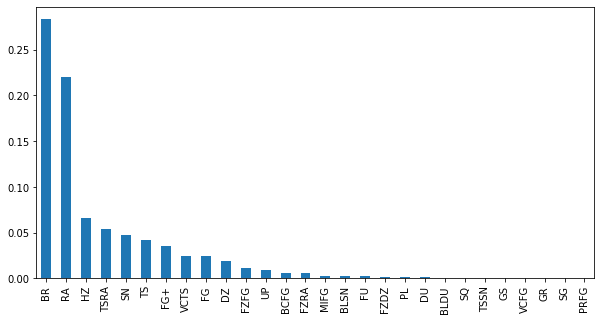

In [94]:
fig,ax = plt.subplots(1,1, figsize=(10,5))
codesum_df.sum().divide(codesum_df.shape[0]).sort_values(ascending=False).plot(kind='bar', ax=ax)

We have that the most common events will be mist, rain, haze, thunderstorm and rain, snow and thunderstorms alone, all of them with 5% of occurrance in the dataset or more. Having this information, now we can append the `codesum_df` dataset to our `sales_data` in order to have more related to each product sales data. Also, we can filter out relevant information further.

In [160]:
#Get fields to remove
to_remove = codesum_df.columns[~codesum_df.columns.isin(['BR','RA', 'HZ', 'TSRA', 'SN', 'TS', 'FG+', 'VCTS', 'FG', 'DZ'])].to_list()
to_remove.append('codesum')
#Append to dataframe
sales_data = sales_data.merge(codesum_df, left_index=True, right_index=True)
# Clean the dataset
sales_data = sales_data[sales_data.columns[~sales_data.columns.isin(to_remove)]]

In [161]:
sales_data.head()

,date,item_nbr,store_nbr,station_nbr,tmax,preciptotal,stnpressure,avgspeed,units,RA,BR,SN,FG+,FG,HZ,TSRA,TS,VCTS,DZ
0,2012-01-01,5,1,1,52.0,0.05,29.78,4.6,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-01-01,9,1,1,52.0,0.05,29.78,4.6,29,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-01-01,45,1,1,52.0,0.05,29.78,4.6,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-01-02,5,1,1,50.0,0.01,29.44,10.3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-01-02,9,1,1,50.0,0.01,29.44,10.3,60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
sales_data.shape

(119376, 19)

# Adding new time-related variables

We are interested in:

* Weekend vs weekday
* Quantity sold the previous day
* Season of the year
* Day of the week (cyclical)
* Month of the year (cyclical)